# Appendix - Code and Graphs

In [2]:
# Parse, decode and remove comments for articles.tsv and links.tsv

import urllib.parse
import csv

def decode_and_clean(input_file, output_file):
    # Read the TSV file, decode URLs, clean comments, and save the results
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8', newline='') as outfile:
        reader = csv.reader(infile, delimiter='\t')  # Reading the TSV file
        writer = csv.writer(outfile, delimiter='\t')  # Writing the cleaned and decoded output

        for row in reader:
            # Skip rows that are comments (start with '#') or empty
            if not row or row[0].startswith('#'):
                continue
            
            # Decode each URL-encoded field in the row
            decoded_row = [urllib.parse.unquote(column) for column in row]
            writer.writerow(decoded_row)

    print(f"Decoded and cleaned URLs saved to {output_file}")

# Input and output file paths for articles
input_file = 'articles.tsv'
output_file = 'decoded_articles.tsv'
decode_and_clean(input_file, output_file)

# Input and output file paths for links
input_file = 'links.tsv'
output_file = 'decoded_links.tsv'
decode_and_clean(input_file, output_file)

Decoded and cleaned URLs saved to decoded_articles.tsv
Decoded and cleaned URLs saved to decoded_links.tsv


In [3]:
# Parse the files and create the graph with articles as nodes and links as egdes

import pandas as pd
import networkx as nx

# Load articles as nodes
articles_df = pd.read_csv('decoded_articles.tsv', sep='\t', header=None, names=['article'])

# Load links as edges
links_df = pd.read_csv('decoded_links.tsv', sep='\t', header=None, names=['source', 'target'])

# Create a directed graph
graph = nx.DiGraph()

# Add nodes from articles
graph.add_nodes_from(articles_df['article'])

# Add edges from links
edges = list(zip(links_df['source'], links_df['target']))
graph.add_edges_from(edges)

print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 4604
Number of edges: 119882


In [4]:
# Formulate graph optimization problem

from gurobipy import Model, GRB, quicksum

def shortest_path_gurobi(graph, source, target):
    """
    Solves the shortest path problem in a directed graph using Gurobi.
    
    Parameters:
        graph (networkx.DiGraph): The input graph.
        source (str): The source node.
        target (str): The target node.

    Returns:
        path (list): The shortest path from source to target.
        cost (float): The cost of the shortest path.
    """
    try:
        # Create a Gurobi Model
        model = Model("ShortestPath")
        model.setParam('OutputFlag', 0)
        model.setParam('LogFile', "gurobi_output.log")

        # Variables
        # Binary decision variable x[i, j] for each edge (i, j) in the graph
        x = model.addVars(graph.edges, vtype=GRB.BINARY, name="x")

        # Objective Function
        # Minimize the total weight of the path
        model.setObjective(quicksum(x[i, j] for i, j in graph.edges), GRB.MINIMIZE)

        # Constraints
        # Flow conservation constraints
        for node in graph.nodes:
            if node == source:
                # Source node: Outflow - Inflow = 1
                model.addConstr(quicksum(x[source, j] for j in graph.neighbors(source)) -
                                quicksum(x[i, source] for i in graph.predecessors(source)) == 1)
            elif node == target:
                # Target node: Inflow - Outflow = 1
                model.addConstr(quicksum(x[i, target] for i in graph.predecessors(target)) -
                                quicksum(x[target, j] for j in graph.neighbors(target)) == 1)
            else:
                # Intermediate nodes: Inflow = Outflow
                model.addConstr(quicksum(x[i, node] for i in graph.predecessors(node)) -
                                quicksum(x[node, j] for j in graph.neighbors(node)) == 0)

        # Solve the Model
        model.optimize()

        # Extract Solution
        if model.status == GRB.OPTIMAL:
            # Extract edges included in the optimal path
            solution_edges = [(i, j) for i, j in graph.edges if x[i, j].x > 0.5]

            # Reconstruct the path from solution edges
            path = [source]
            while path[-1] != target:
                for u, v in solution_edges:
                    if u == path[-1]:
                        path.append(v)
                        break

            cost = model.objVal
            return path, cost
        else:
            print("No optimal solution found.")
            return None, None

    except Exception as e:
        print(f"Error: {e}")
        return None, None

In [5]:
# # Test with any source and target node

# source_node = "Áedán_mac_Gabráin"
# target_node = "Ireland"

# # Solve the shortest path problem
# path, cost = shortest_path_gurobi(graph, source_node, target_node)

# print("Shortest Path:", path)
# print("Cost of the Path:", cost)

In [6]:
import random
import matplotlib.pyplot as plt

def find_largest_shortest_path(graph, num_tests=1):
    """
    Randomly tests pairs of nodes to find the largest shortest path in the graph.
    
    Parameters:
        graph (networkx.DiGraph): The input graph.
        num_tests (int): Number of random tests to run.
    
    Returns:
        best_path (list): The longest shortest path found.
        best_cost (float): The cost of the longest shortest path.
    """
    best_path = []
    best_cost = 0

    # Convert nodes to a list
    node_list = list(graph.nodes)

    for _ in range(num_tests):
        # Randomly pick a source and target node from the list
        source, target = random.sample(node_list, 2)
        
        print(f"Testing path from {source} to {target}")
        path, cost = shortest_path_gurobi(graph, source, target)
        print(f"Shortest Path is {path} with a cost of {cost}")

        # Check if a valid solution exists and update the best path
        if path and cost > best_cost:
            best_path = path
            best_cost = cost

    return best_path, best_cost

In [7]:
def display_path(graph, path, method):
    """
    Displays the graph highlighting the path found.

    Parameters:
        graph (networkx.DiGraph): The input graph.
        path (list): The path to highlight.
    """
    if not path or len(path) < 2:
        print("Invalid or empty path provided.")
        return

    # Create a subgraph with only the nodes and edges on the path
    path_edges = list(zip(path, path[1:]))  # Create edges from consecutive nodes
    subgraph = graph.edge_subgraph(path_edges)  # Extract subgraph with path edges

    plt.figure(figsize=(8, 6))

    # Layout for better visualization
    pos = nx.spring_layout(subgraph)

    # Draw the subgraph
    nx.draw(subgraph, pos, with_labels=True, node_size=600, font_size=10, 
            node_color='lightblue', edge_color='red', width=2)
    plt.title(f"Shortest Path from {path[0]} to {path[-1]} - {method}")
    plt.show()

## Play Wikispeedia using random nodes

Testing path from Mary_I_of_England to Red_Panda
Set parameter Username
Set parameter LicenseID to value 2600134
Academic license - for non-commercial use only - expires 2025-12-17
Shortest Path is ['Mary_I_of_England', 'England', 'King_Arthur', 'Bear', 'Red_Panda'] with a cost of 4.0
Testing path from AK-47 to Six-party_talks_concerning_North_Korea's_nuclear_program
No optimal solution found.
Shortest Path is None with a cost of None
Testing path from Nauru to Charlemagne
Shortest Path is ['Nauru', 'Football_(soccer)', 'Hamburg', 'Charlemagne'] with a cost of 3.0
Testing path from Tropical_Storm_Larry_(2003) to Crimson-collared_Tanager
No optimal solution found.
Shortest Path is None with a cost of None
Testing path from John_McEnroe to Hip_hop_music
Shortest Path is ['John_McEnroe', 'United_States', 'Hip_hop_music'] with a cost of 2.0
Testing path from Surtsey to Oleg_of_Novgorod
Shortest Path is ['Surtsey', 'France', 'Judaism', 'Khazars', 'Oleg_of_Novgorod'] with a cost of 4.0
Testi

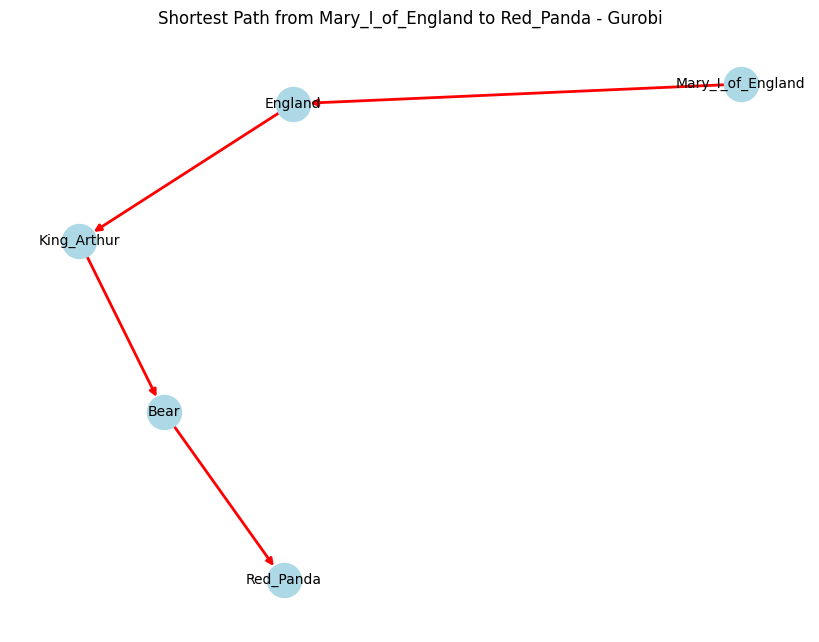

In [8]:
# Run the function to play wikispeedia
num_random_tests = 20
best_path, best_cost = find_largest_shortest_path(graph, num_tests=num_random_tests)

print("\nLargest Shortest Path:", best_path)
print("Cost of the Path:", best_cost)

# Display the result graphically
if best_path:
    display_path(graph, best_path, 'Gurobi')
else:
    print("No valid paths found.")

## Approximation Algorithms

### 1. Randomized Sampling + Dijkstra Approximation

In [9]:
# Randomized Sampling + Dijkstra Approximation

def find_longest_shortest_path_approx(graph, num_samples=1000):
    """
    Approximation to find the longest shortest path using random sampling.
    """
    nodes = list(graph.nodes)
    longest_path = []
    max_distance = 0

    for _ in range(num_samples):
        # Randomly pick two nodes
        source, target = random.sample(nodes, 2)

        try:
            # Compute shortest path
            path = nx.shortest_path(graph, source=source, target=target, weight='weight')
            distance = nx.shortest_path_length(graph, source=source, target=target, weight='weight')

            # Update longest shortest path
            if distance > max_distance:
                max_distance = distance
                longest_path = path
        except nx.NetworkXNoPath:
            # No path exists between source and target
            continue

    return longest_path, max_distance

Longest Shortest Path (Approximation): ['Libreville', 'France', 'Republic_of_Ireland', 'Train', 'Refrigerator_car', 'Stock_car_(rail)', 'Northern_Pacific_Railway', 'Timken_1111']
Max Distance: 7


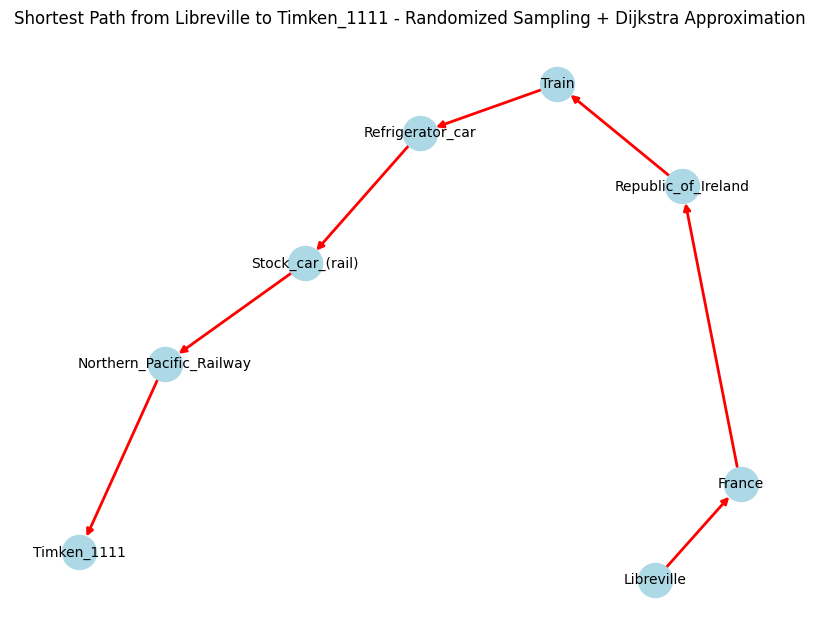

In [10]:
# Find the longest shortest path
longest_path, max_distance = find_longest_shortest_path_approx(graph, num_samples=1500)
print("Longest Shortest Path (Approximation):", longest_path)
print("Max Distance:", max_distance)

# Visualize the path
display_path(graph, longest_path, 'Randomized Sampling + Dijkstra Approximation')

### 2. Landmark Based Approximation

In [11]:
# Landmark Based Approximation

def landmark_based_longest_shortest_path(graph, num_landmarks):
    """
    Finds an approximation of the longest shortest path using landmarks.
    """
    landmarks = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:num_landmarks]
    landmarks = [node for node, _ in landmarks]
    longest_path = []
    max_distance = 0

    print(f"Selected Landmarks: {landmarks}")

    # Compute shortest paths from/to each landmark
    for landmark in landmarks:
        # Shortest paths from the landmark
        try:
            distances_from_landmark = nx.single_source_dijkstra_path_length(graph, source=landmark, weight='weight')
            farthest_node = max(distances_from_landmark, key=distances_from_landmark.get)
            distance = distances_from_landmark[farthest_node]

            # Update longest path if a larger distance is found
            if distance > max_distance:
                max_distance = distance
                longest_path = nx.shortest_path(graph, source=landmark, target=farthest_node, weight='weight')

        except nx.NetworkXNoPath:
            continue  # No paths from the landmark

        # Shortest paths to the landmark
        try:
            distances_to_landmark = nx.single_source_dijkstra_path_length(graph.reverse(copy=True), source=landmark, weight='weight')
            farthest_node = max(distances_to_landmark, key=distances_to_landmark.get)
            distance = distances_to_landmark[farthest_node]

            # Update longest path if a larger distance is found
            if distance > max_distance:
                max_distance = distance
                longest_path = nx.shortest_path(graph, source=farthest_node, target=landmark, weight='weight')

        except nx.NetworkXNoPath:
            continue  # No paths to the landmark

    return longest_path, max_distance

Selected Landmarks: ['United_States', 'United_Kingdom', 'Europe', 'France', 'England', 'Germany', 'World_War_II', 'English_language', 'India', 'Africa', 'London', 'Japan', 'Australia', 'Italy', 'Canada', 'Spain', 'Russia', 'China', 'Scientific_classification', 'Animal', 'Asia', 'North_America', 'World_War_I', 'Latin', 'Netherlands', '19th_century', 'List_of_countries_by_system_of_government', 'Scotland', 'United_Nations', 'Egypt', 'Turkey', 'Paris', 'South_Africa', 'Soviet_Union', 'Israel', '20th_century', 'French_language', 'Christianity', 'Ireland', 'Time_zone', 'Sweden', 'New_York_City', 'Earth', 'New_Zealand', 'Islam', 'European_Union', 'Portugal', 'Atlantic_Ocean', "People's_Republic_of_China", 'Greece', 'Jew', 'Argentina', 'Poland', 'Chordate', 'South_America', 'Brazil', 'Mexico', 'Iran', 'Water', 'Currency', 'Middle_Ages', 'Binomial_nomenclature', 'List_of_countries', 'Lebanon', 'Roman_Catholic_Church', 'German_language', 'Human', 'Agriculture', 'Switzerland', 'Bird', 'Middle_Ea

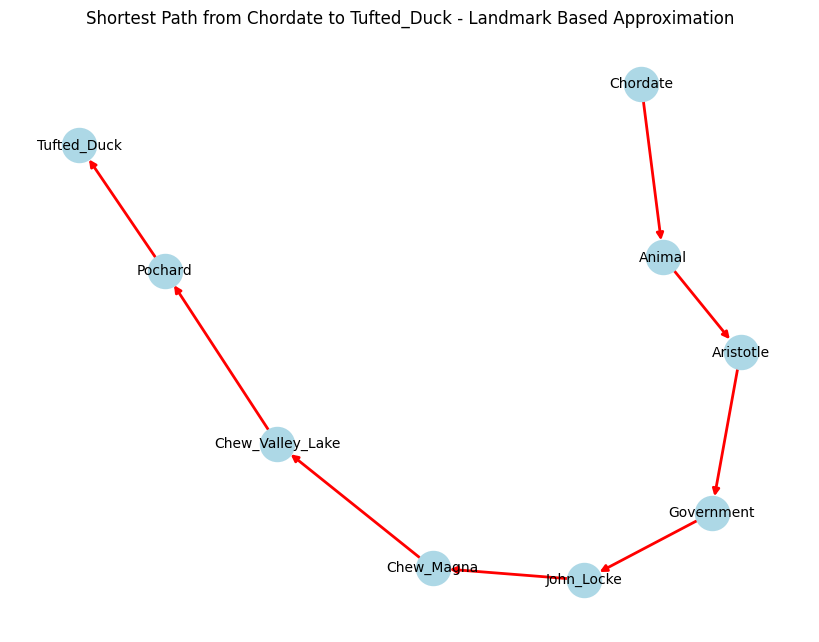

In [12]:
# Find the longest shortest path
longest_path, max_distance = landmark_based_longest_shortest_path(graph, num_landmarks=100)
print("Longest Shortest Path (Approximation):", longest_path)
print("Max Distance:", max_distance)

# Visualize the path
display_path(graph, longest_path, 'Landmark Based Approximation')